In [2]:
import requests
import json
import math
import numpy as np

import matplotlib.pyplot as plt


class OI_barchart:
  def __init__(self,index,Expiry):
    self.index=index
    self.Expiry=Expiry

  def ltp(self):
    url_indices= "https://www.nseindia.com/api/allIndices"
    headers = {'User-Agent': 'Mozilla/5.0'}
    while True:
        page = requests.get(url_indices, headers=headers)
        if page.status_code == 200:
            break
    data = json.loads(page.text)
    for index in data["data"]:
        if index["index"]==self.index:
            ltp = index["last"]
    return ltp

  def get_OIData(self,num):
    spot = self.ltp()
    if self.index == "NIFTY 50":
        symbol = 'NIFTY'
    elif self.index == "NIFTY BANK":
        symbol = 'BANKNIFTY'
    elif self.index == "NIFTY FINANCIAL SERVICES":
        symbol = 'FINNIFTY'
    elif self.index == "NIFTY MIDCAP SELECT":
        symbol = 'MIDCPNIFTY'
    else:
        return "Invalid Index"

    new_url ="https://www.nseindia.com/api/option-chain-indices?symbol="+ symbol
    headers = {'User-Agent': 'Mozilla/5.0'}
    while True:
        page = requests.get(new_url, headers=headers)
        if page.status_code == 200:
            break
    data = json.loads(page.text)
    currExpiryDate = data["records"]["expiryDates"][self.Expiry]
    temp =len(data['records']['data'])
    strike = np.zeros((temp))
    X = np.zeros(((2*num)+1,5))
    diff = np.zeros((temp,1))
    count =0
    for item in data['records']['data']:
        if item["expiryDate"] == currExpiryDate:
            skp =  item['strikePrice']
            strike[count] = item['strikePrice']
            diff[count] =[ abs(skp - spot)]
            tt=abs(skp - spot)
            count = count +1

    new_diff = diff[0:count]
    center = np.argmin(new_diff)
    count = 0
    for item in data['records']['data']:
        if item["expiryDate"] == currExpiryDate:
          if item['strikePrice']>=  strike[center-num] and item['strikePrice']<=strike[center+num]:
            X[count,:] = [item['strikePrice'],item['CE']['openInterest'],item['CE']['changeinOpenInterest'],item['PE']['openInterest'],item['PE']['changeinOpenInterest']]
            count = count +1
    return X,strike,center,currExpiryDate,spot

  def plot_OIBarchart(self,num=10):
      X,strike,center,currExpiryDate,spot = self.get_OIData(num)
      xpos = X[0:,0]
      Pw = 80*(xpos[1] -xpos[0])/100
      Cw = 50*(xpos[1] -xpos[0])/100
      PE_value = X[0:,3]
      CE_value = X[0:,1]
      lastP = strike[center]


      lw = 10*(xpos[1] -xpos[0])/100
      cp = 110*(max(X[0:,1].max(),X[0:,3].max()))/100
      dp = 112*(max(X[0:,1].max(),X[0:,3].max()))/100

      CE_chvalue = X[0:,2]
      PE_chvalue = X[0:,4]
      fig, (axs1, axs2) = plt.subplots(2, 1, figsize = (15, 8))
      #style.use('ggplot')
      fig.suptitle(self.index +' Option Chain'+" (Expiry Date= "+currExpiryDate+")")

      axs1.bar(xpos, PE_value,color ='red',width = Pw)
      axs1.bar(xpos, CE_value,color ='green',width = Cw)
      axs1.bar(lastP, cp,color ='black',width = lw)
      axs1.text(lastP-Pw,dp ,spot,color ='blue',fontsize=12)
      axs2.title.set_text('CHANGE IN OI')
      axs2.bar(xpos, PE_chvalue,color ='red',width = Pw)
      axs2.bar(xpos, CE_chvalue,color ='green',width = Cw)

In [7]:
Nifty = OI_barchart("NIFTY 50",0)                   #(0 = current Expiry, 1= next Expiry .....)
Banknifty = OI_barchart("NIFTY BANK",0)
FinNIFTY = OI_barchart("NIFTY FINANCIAL SERVICES",0)
MIDCPNIFTY = OI_barchart("NIFTY MIDCAP SELECT",0)


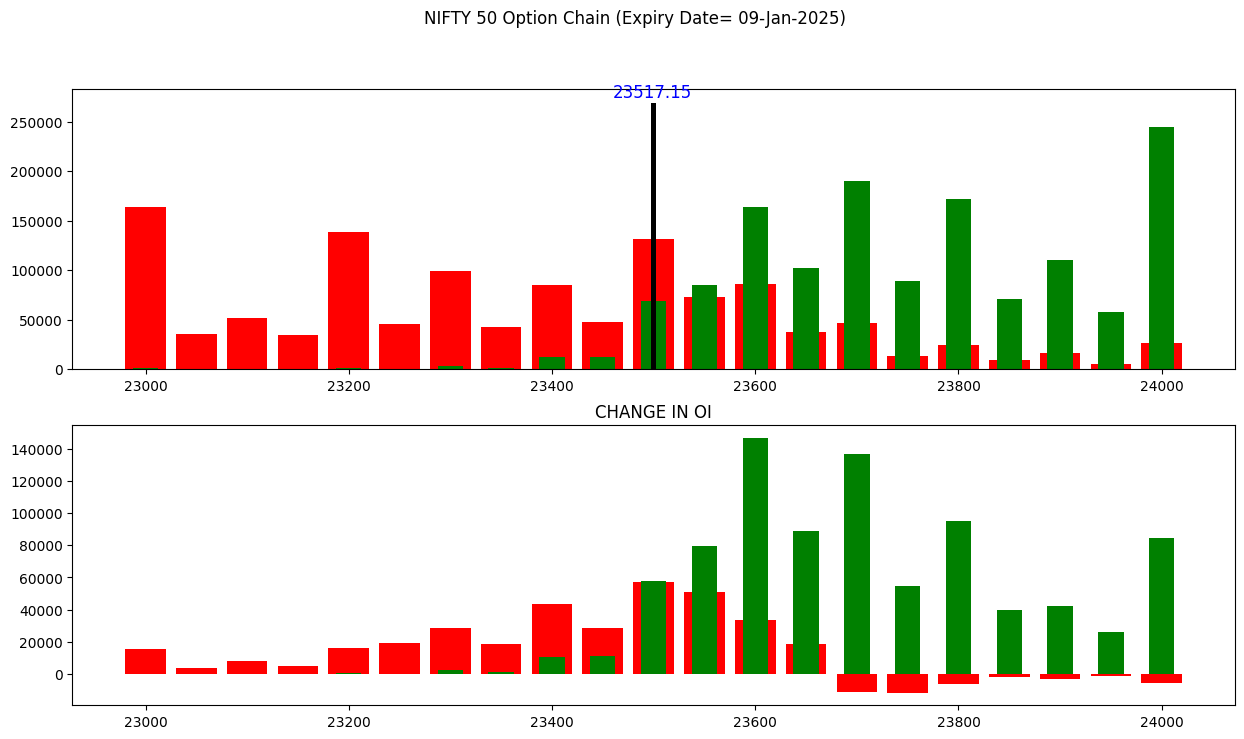

In [8]:
Nifty.plot_OIBarchart(10)              #(10 = 10 OTM call and 10 OTM Put)

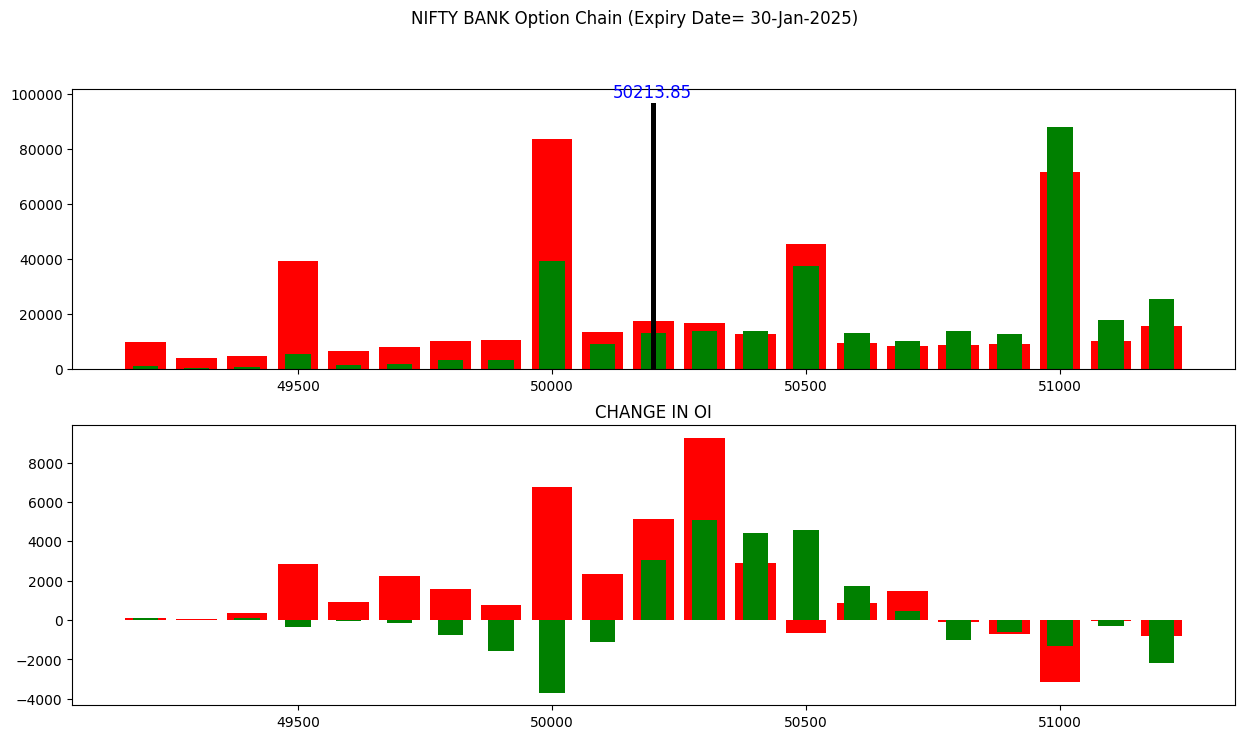

In [5]:
Banknifty.plot_OIBarchart(10)